## Coding Challenge

- 2021年におけるパイプの故障率を予測するモデルを構築する
- モデルの評価指標を作成し、それの基づいてモデルを評価する



In [1]:
import pandas as pd
import numpy as np
import joblib
import sys, os
import dateutil
from datetime import datetime, timedelta
from glob import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
sys.path.append('../..')
from utils import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df_pipe = pd.read_csv('./fracta_Dec3.csv')
df_wk = df_pipe.copy()
display(df_wk.head())

,pipe_id,install_year,material,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,...,env_dat_135,env_dat_136,env_dat_137,env_dat_138,env_dat_139,env_dat_140,env_dat_141,env_dat_142,env_dat_143,env_dat_144
0,P0000000000,1985,D,20.32,NaN,623.542175,18.052843,14.161422,10.268579,159.662827,...,554.479675,20.000000,0.000038,438.628143,27.000000,3085.786865,0.002728,0.311803,0.0,0.0
1,P0000000001,1934,C,15.24,NaN,644.830017,17.790001,13.830000,9.870000,257.001221,...,276.357605,9.200573,0.304329,239.719299,32.571018,3188.292236,0.003291,0.322161,0.0,0.0
2,P0000000002,1904,C,20.32,NaN,604.570007,18.219999,14.350000,10.470000,225.165039,...,236.882950,4.872639,0.182168,500.638367,28.978306,4542.257324,0.002928,0.458972,0.0,0.0
3,P0000000003,1979,D,15.24,NaN,573.424011,17.671381,14.132636,10.586646,170.244339,...,321.886658,12.353504,0.480517,295.554504,41.983772,4521.720215,0.004242,0.456897,0.0,0.0
4,P0000000004,1987,D,20.32,NaN,583.429993,18.280001,14.350000,10.420000,171.034073,...,758.841431,25.052542,0.021532,778.687256,25.842377,4978.718262,0.002611,0.503074,0.0,0.0


- 全体で56774件のレコードが存在し、そのうち故障件数は3144
- およそ5.5%程に故障年が存在する

In [3]:
total = len(df_wk)
death = len(df_wk['break_year'].notna())
birth = len(df_wk['install_year'].notna())

display(total)
display(death)
display(death/total)

56774

56774

1.0

In [4]:
df_wk = pd.get_dummies(df_wk, columns=['material'])

In [5]:
# df_wk['pipe_id_int']=df_wk['pipe_id'].apply(lambda x: x[1:] if x[0] == 'P' else None).astype(int)

- 故障したものについて年数を算出する

3144

<AxesSubplot:>

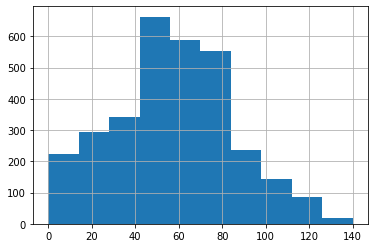

In [6]:
df_break=df_wk[df_wk['break_year'].notna()].copy()
# df_break['break_year'].hist()

df_break['age'] = df_break['break_year'] - df_break['install_year']
display(len(df_break))
df_break['age'].hist()

パイプの年齢の平均を可視化

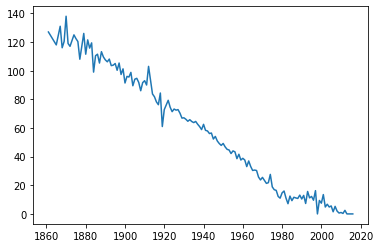

In [7]:
df_stats = df_break.set_index('install_year')
df_stats = df_stats.groupby('install_year').mean()
plt.plot(df_stats['age'])

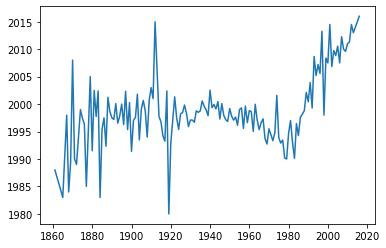

In [8]:
plt.plot(df_stats['break_year'])

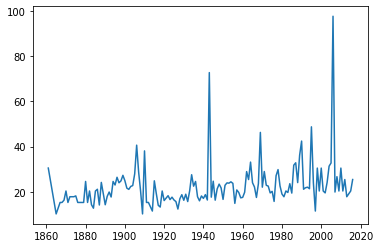

In [9]:
plt.plot(df_stats['diameter'])

正常なものについて年数を算出します。

53630

<AxesSubplot:>

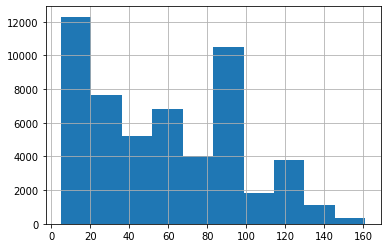

In [10]:
df_alive=df_wk[df_wk['break_year'].isna()]
# df_break['break_year'].hist()

df_alive['age'] = 2022 - df_alive['install_year']
display(len(df_alive))
df_alive['age'].hist()

<AxesSubplot:>

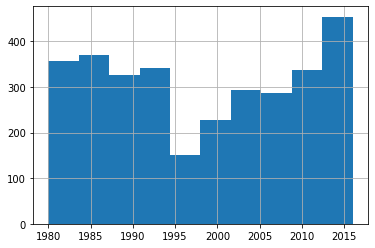

In [11]:
df_wk[df_wk['break_year'].notna()]['break_year'].astype(int).hist()

故障年は1980年から2016年までです

<AxesSubplot:>

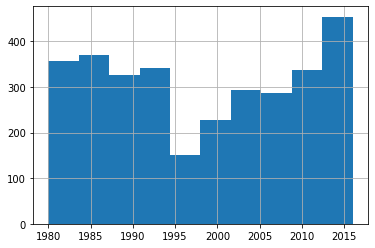

In [12]:
df_break['break_year'].hist()

In [13]:
df_break.head()

,pipe_id,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,...,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S,age
41,P0000000041,1983,20.32,1990.0,568.710022,17.559999,14.100000,10.640000,0.023671,0.000005,...,0.000505,0.383964,0.0,0.0,0,0,1,0,0,7.0
52,P0000000052,1968,20.32,1995.0,580.960022,18.260000,14.340000,10.420000,299.776337,0.037117,...,0.001921,0.453269,0.0,1.0,0,0,1,0,0,27.0
63,P0000000063,1991,10.16,2003.0,615.322571,18.112228,14.210916,10.309492,105.444649,0.010701,...,0.002991,0.310529,0.0,0.0,0,0,1,0,0,12.0
68,P0000000068,1924,20.32,2015.0,610.489990,17.080000,13.870000,10.650000,113.146187,0.007912,...,0.002717,0.536662,0.0,0.0,0,1,0,0,0,91.0
87,P0000000087,1947,15.24,1995.0,644.830017,17.790001,13.830000,9.870000,86.456589,0.006315,...,0.002754,0.321194,0.0,0.0,0,1,0,0,0,48.0


In [14]:
df_break.head()

,pipe_id,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,...,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S,age
41,P0000000041,1983,20.32,1990.0,568.710022,17.559999,14.100000,10.640000,0.023671,0.000005,...,0.000505,0.383964,0.0,0.0,0,0,1,0,0,7.0
52,P0000000052,1968,20.32,1995.0,580.960022,18.260000,14.340000,10.420000,299.776337,0.037117,...,0.001921,0.453269,0.0,1.0,0,0,1,0,0,27.0
63,P0000000063,1991,10.16,2003.0,615.322571,18.112228,14.210916,10.309492,105.444649,0.010701,...,0.002991,0.310529,0.0,0.0,0,0,1,0,0,12.0
68,P0000000068,1924,20.32,2015.0,610.489990,17.080000,13.870000,10.650000,113.146187,0.007912,...,0.002717,0.536662,0.0,0.0,0,1,0,0,0,91.0
87,P0000000087,1947,15.24,1995.0,644.830017,17.790001,13.830000,9.870000,86.456589,0.006315,...,0.002754,0.321194,0.0,0.0,0,1,0,0,0,48.0


In [15]:
# import math
# def draw_graph(df_product):
#     cols = 5
#     nums = 145
#     rows = math.ceil(nums / cols)
#     fig = plt.figure(facecolor='white', figsize=(10 * cols, 10 * rows))
    
#     # for i, (name, code) in enumerate(zip(df_product['製品名'], df_product['製品コード'])):
#     for i in range(nums):
#         ax = fig.add_subplot(rows, cols, i + 1)
#         label = 'env_dat_'+str(i)
#         df = df_product[label]
#         ax.hist(df)
#         plt.xticks(rotation=90)
#         ax.set_title(f'{label}')
#         ax.set_ylabel(f'{label}')
#         # ax.set_xlabel('受注月')
#     fig.tight_layout()
#     fig.show()
#     fig.savefig(f'{label}.png')

In [16]:
# draw_graph(df_break)

<AxesSubplot:>

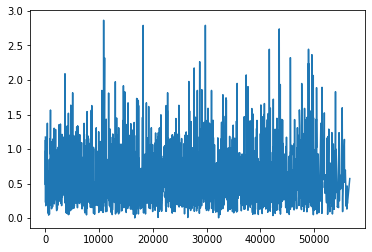

In [17]:
df_break['env_dat_66'].plot()

In [18]:
X = df_break.drop(['age', 'pipe_id','break_year'], axis=1)
y = df_break['age']

In [19]:
drop_list = ['env_dat_31',
    'env_dat_40',
    'env_dat_48',
    'env_dat_80',
    'env_dat_99',
    'env_dat_123',
    'env_dat_126',
    'env_dat_127',
    'env_dat_27',
    'env_dat_45',
    'env_dat_49',
    'env_dat_51',
    'env_dat_77',    
    'env_dat_78',
    'env_dat_124',
    'env_dat_36',
    'env_dat_130', 
    'env_dat_55',
    'env_dat_118',
    'env_dat_35',
    'env_dat_76',
    'env_dat_28',
    'env_dat_52',
    'env_dat_56',
    'env_dat_125',
    'env_dat_75',
    'env_dat_79',
    'env_dat_128',
    'env_dat_46',
    'env_dat_37', 
    'env_dat_44', 
    'env_dat_58', 
    'env_dat_33', 
    'env_dat_43', 
    'env_dat_47', 
    'env_dat_50', 
    'env_dat_96', 
    'env_dat_84', 
    'env_dat_17', 
    'env_dat_90', 
    'env_dat_30', 
    'env_dat_83', 
    'env_dat_42', 
    'env_dat_53', 
    'env_dat_117', 
    'env_dat_91', 
    'env_dat_143', 
    'env_dat_85', 
    'env_dat_81', 
    'env_dat_100',  
    'env_dat_100',    
    'age', 
    'pipe_id',
    'break_year',
    #'install_year',
    ]

X = df_break.drop(drop_list, axis=1)
A = df_alive.drop(drop_list, axis=1)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
### optunaつかう
# LightGBM用のデータセットに変換
# import optuna.integration.lightgbm as lgb_o
import lightgbm as lgb_o
# from lightgbm import Dataset
import xgboost as xgb

train = lgb_o.Dataset(X_train, y_train)
val = Dataset(X_test, y_test)

# train = xgb.DMatrix(X_train, y_train)
# val = xgb.DMatrix(X_test, y_test)


# %%time
# ハイパーパラメータサーチ&モデル構築
params = {'objective': 'regression',
        'metric': 'rmse',
        'random_seed':0} 

params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_seed': 0,
        'feature_pre_filter': False,
        'lambda_l1': 0.05,
        'lambda_l2': 0.05,
        'num_leaves': 1000,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 100,
        # 'min_data_in_leaf': 5,
        'min_child_samples': 5,
        'num_iterations': 1000,
        'early_stopping_round': 3000    
}

gbm_o = lgb_o.train(params,
                    train,
                    valid_sets=val,
                    early_stopping_rounds=3000,
                    verbose_eval=20000)

# gbm_o = xgb.train(params,
#                     train,
#                     # valid_sets=val,
#                     early_stopping_rounds=3000,
#                     verbose_eval=20000)                    

# ベストパラメータの取得


best_params = gbm_o.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

import lightgbm as lgb

## 新たにlightGBMで全trainデータ再学習させる場合 ##
# params_best = dict(best_params.items())

# gbm = lgb.LGBMRegressor(**params_best,random_state=0)

# gbm.fit(train_X, train_y)
# y_pred_train = gbm.predict(train_X, num_iteration=gbm_o.best_iteration)
# y_pred_test = gbm.predict(test_X, num_iteration=gbm_o.best_iteration)
###################################################

## lightGBM-optunaで学習した(train_test_splitでval有)モデルで推論する場合
y_pred_train = gbm_o.predict(X_train, num_iteration=gbm_o.best_iteration)
y_pred_test = gbm_o.predict(X_test, num_iteration=gbm_o.best_iteration)
############################################################################

# # モデルのインスタンスの作成
# model = lgb.LGBMRegressor()


# model.fit(train_X, train_y) # モデルの学習
# y_pred_train = model.predict(train_X)


# テストデータの予測
# y_pred_test = model.predict(test_X)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# print('MAPE: {:.2f}%'.format(mean_absolute_percentage_error(test_y, y_pred_test)*100))
# print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(test_y, y_pred_test))))
# print('MAE: {:.2f}'.format(mean_absolute_error(test_y, y_pred_test)))
lgb.plot_importance(gbm_o, figsize=(6, 9))

ImportError: cannot import name 'Dataset' from 'lightgbm' (unknown location)

In [ ]:
y_pred_train = gbm_o.predict(X_train, num_iteration=gbm_o.best_iteration)
y_pred_test = gbm_o.predict(X_test, num_iteration=gbm_o.best_iteration)

NameError: name 'gbm_o' is not defined

In [ ]:
# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

scores = calculate_scores(y_test, y_pred_test)
display(scores)

,R2,MAE,MSE,RMSE
scores,0.789744,10.568473,167.377174,12.937433


2106

(array([131., 156., 252., 401., 520., 338., 143., 104.,  48.,  13.]),
 array([ -2.59613108,  11.66488047,  25.92589202,  40.18690357,
         54.44791511,  68.70892666,  82.96993821,  97.23094976,
        111.49196131, 125.75297285, 140.0139844 ]),
 <BarContainer object of 10 artists>)

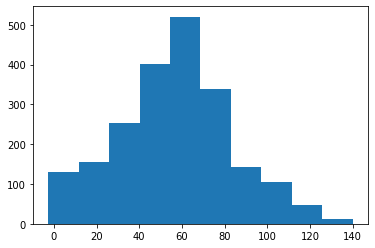

In [ ]:
display(len(y_pred_train))
plt.hist(y_pred_train)

<AxesSubplot:>

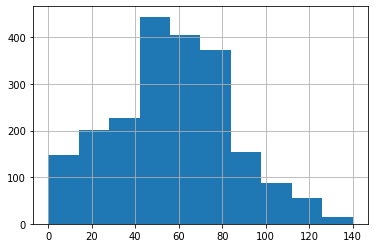

In [ ]:
y_train.hist()

1038

(array([ 61.,  64.,  97., 165., 208., 259.,  62.,  63.,  46.,  13.]),
 array([ -0.33912669,  12.46204403,  25.26321475,  38.06438548,
         50.8655562 ,  63.66672692,  76.46789764,  89.26906837,
        102.07023909, 114.87140981, 127.67258053]),
 <BarContainer object of 10 artists>)

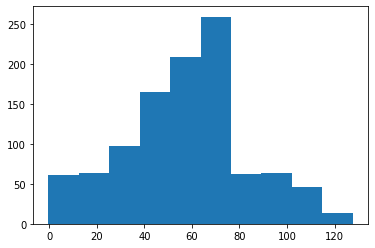

In [ ]:
display(len(y_pred_test))
plt.hist(y_pred_test)

<AxesSubplot:>

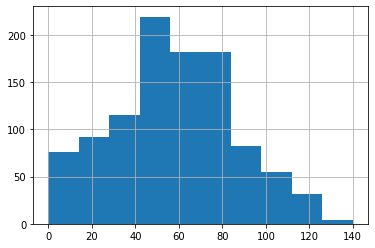

In [ ]:
y_test.hist()

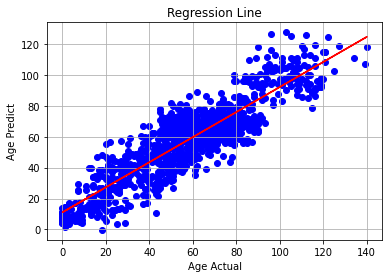

In [ ]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

y_list_test = y_test.to_numpy()
lr.fit(y_list_test.reshape(-1, 1), y_pred_test)

plt.scatter(y_list_test, y_pred_test, color = 'blue')         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(y_list_test, lr.predict(y_list_test.reshape(-1, 1)), color = 'red') # 回帰直線をプロット

plt.title('Regression Line')               # 図のタイトル
plt.xlabel('Age Actual') # x軸のラベル
plt.ylabel('Age Predict')    # y軸のラベル
plt.grid()                                 # グリッド線を表示

plt.show()          

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

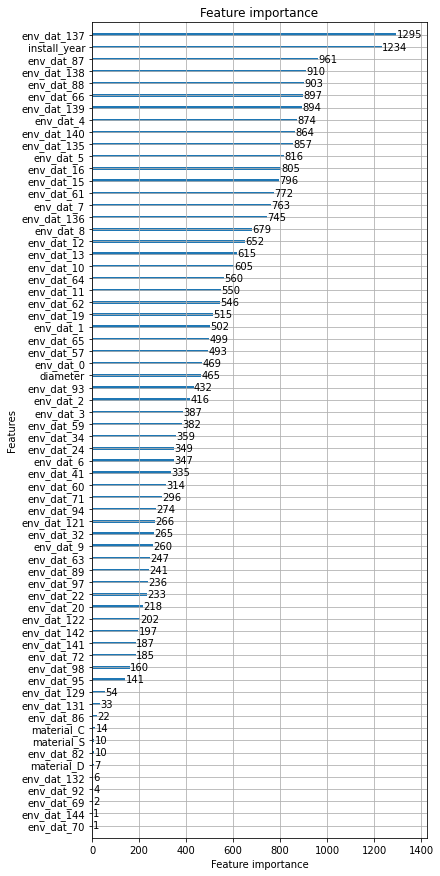

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# print('MAPE: {:.2f}%'.format(mean_absolute_percentage_error(test_y, y_pred_test)*100))
# print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(test_y, y_pred_test))))
# print('MAE: {:.2f}'.format(mean_absolute_error(test_y, y_pred_test)))
lgb.plot_importance(gbm_o, figsize=(6, 15))

### 現在生存するデータ寿命を予測する

In [ ]:
A

,install_year,diameter,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,env_dat_6,env_dat_7,...,env_dat_139,env_dat_140,env_dat_141,env_dat_142,env_dat_144,material_A,material_C,material_D,material_O,material_S
0,1985,20.32,623.542175,18.052843,14.161422,10.268579,159.662827,0.010340,0.030000,0.000000,...,27.000000,3085.786865,0.002728,0.311803,0.0,0,0,1,0,0
1,1934,15.24,644.830017,17.790001,13.830000,9.870000,257.001221,0.007786,0.030000,0.002000,...,32.571018,3188.292236,0.003291,0.322161,0.0,0,1,0,0,0
2,1904,20.32,604.570007,18.219999,14.350000,10.470000,225.165039,0.014548,0.006675,0.002439,...,28.978306,4542.257324,0.002928,0.458972,0.0,0,1,0,0,0
3,1979,15.24,573.424011,17.671381,14.132636,10.586646,170.244339,0.014938,0.005481,0.000583,...,41.983772,4521.720215,0.004242,0.456897,0.0,0,0,1,0,0
4,1987,20.32,583.429993,18.280001,14.350000,10.420000,171.034073,0.025906,0.008322,0.000000,...,25.842377,4978.718262,0.002611,0.503074,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56769,2016,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,...,26.000000,2504.886719,0.002627,0.253106,0.0,0,0,1,0,0
56770,2016,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,...,26.000000,2504.886719,0.002627,0.253106,0.0,0,0,1,0,0
56771,2016,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,...,26.000000,2504.886719,0.002627,0.253106,0.0,0,0,1,0,0
56772,2016,20.32,610.280029,18.280001,14.340000,10.400000,190.049469,0.010628,0.030000,0.001782,...,26.000000,2504.886719,0.002627,0.253106,0.0,0,0,1,0,0


年齢を予測します。

In [ ]:
pred = gbm_o.predict(A, num_iteration=gbm_o.best_iteration)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

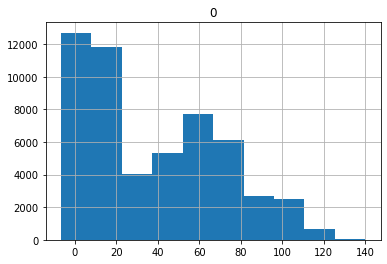

In [ ]:
pd.DataFrame(pred).hist()

In [ ]:
A['break_pred']=A['install_year'].add(pred, axis=0).astype(int)

予測された破損件数のヒストグラムを見てみます。

<AxesSubplot:>

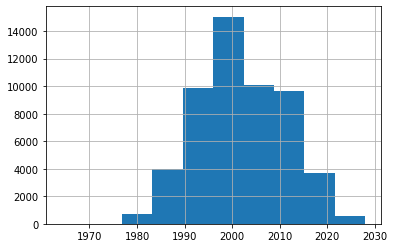

In [ ]:
A['break_pred'].hist()

<AxesSubplot:>

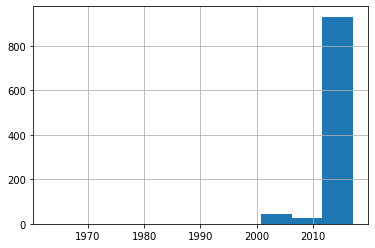

In [ ]:
A[A['break_pred'] > 2020]['install_year'].hist()

### 2021年にパイプが破損する確率を求めたい
- S: 2020年には生きている（正常である）
- D: 2021年に死ぬ（破損する）

S, D が以上で与えられている時、求める確率は以下の通りです。

P(D|S) = P(D)/P(S)

In [ ]:
p_s = (len(A) - len(A[A['break_pred'] <= 2020])) / len(A) 

display(p_s)

0.018702218907327987

In [ ]:
p_d = len(A[A['break_pred'] == 2021]) / len(A)

display (p_d)

0.007589035987320529

In [ ]:
p_2021 = p_d / p_s

display(p_2021)


0.40578265204386843

2021年にパイプが破損する確率は約41％の予測になります。